# 第4章 パーセプトロン：分類アルゴリズムの基礎

## 「04-perceptron」の解説

ITエンジニアための機械学習理論入門「第4章 パーセプトロン:分類アルゴリズムの基礎」で使用しているサンプルコード「04-perceptron.py」の解説です。

※ 解説用にコードの内容は少し変更しています。

### 分類が容易なトレーニングセットの場合

はじめに必要なモジュールをインポートしておきます。

関数 multivariate_normal は、多次元の正規分布に従う乱数を生成するために利用します。

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import multivariate_normal

トレーニング用データを生成する関数を用意します。

平面上の○☓の2種類のデータについて、それぞれの「個数、中心座標、分散」を引数で指定します。

In [0]:
def prepare_dataset(n1, mu1, variance1, n2, mu2, variance2):
    df1 = DataFrame(multivariate_normal(mu1, np.eye(2)*variance1 ,n1),
                    columns=['x','y'])
    df1['type'] = 1
    df2 = DataFrame(multivariate_normal(mu2, np.eye(2)*variance2, n2),
                    columns=['x','y'])
    df2['type'] = -1
    df = pd.concat([df1,df2], ignore_index=True)
    df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
    return df

実際にデータを作成します。

In [0]:
train_set = prepare_dataset(20, [15,10], 15, 30, [0,0], 15)

先頭から10個分のデータを確認してみます。

type=±1 がデータの種類に対応します。

In [4]:
train_set[:10]

,x,y,type
0,-7.574213,7.686074,-1
1,-4.703909,-4.247857,-1
2,14.049312,13.242940,1
3,-5.536590,-5.683702,-1
4,1.945506,-2.959420,-1
5,13.247167,9.527592,1
6,5.219884,5.572851,-1
7,-0.252023,-2.345727,-1
8,-3.038161,2.195652,-1
9,-9.937858,-4.446982,-1


パーセプトロンによる分類を実施する関数を用意します。

生成したトレーニングセットを引数で渡すと、30回のIterationを実施した後に、この間のパラメーターの変化を記録したリストと最終的な誤分類率を返します。

In [0]:
def run_train(train_set):
    # パラメータの初期値とbias項の設定
    w0 = w1 = w2 = 0.0
    bias = 0.5 * (train_set.x.abs().mean() + train_set.y.abs().mean())

    # Iterationを実施
    paramhist = DataFrame([[w0,w1,w2]], columns=['w0','w1','w2'])
    for i in range(30):
        for index, point in train_set.iterrows():
            x, y, type = point.x, point.y, point.type
            if type * (w0*bias + w1*x + w2*y) <= 0:
                w0 += type * bias
                w1 += type * x
                w2 += type * y
        paramhist = paramhist.append(Series([w0,w1,w2], ['w0','w1','w2']),
                                     ignore_index=True)
    
    # 判定誤差の計算
    err = 0.0
    for index, point in train_set.iterrows():
        x, y, type = point.x, point.y, point.type
        if type * (w0*bias + w1*x + w2*y) <= 0:
            err += 1
    err_rate = err * 100 / len(train_set)
    
    return paramhist, err_rate

トレーニングを実施します。

In [0]:
paramhist, err_rate = run_train(train_set)

パラメーターの変化の先頭部分を確認してみます。

In [7]:
paramhist[:5]

,w0,w1,w2
0,0.000000,0.000000,0.000000
1,-12.827908,14.458137,2.943435
2,-19.241863,21.346682,5.971683
3,-25.655817,20.283625,4.065339
4,-25.655817,20.283625,4.065339


分類結果をグラフに可視化する関数を用意します。

In [0]:
# 結果の表示
def show_result(subplot, train_set, w0, w1, w2, err_rate):
    train_set1 = train_set[train_set['type']==1]
    train_set2 = train_set[train_set['type']==-1]
    bias = 0.5 * (train_set.x.abs().mean() + train_set.y.abs().mean())
    ymin, ymax = train_set.y.min()-5, train_set.y.max()+10
    xmin, xmax = train_set.x.min()-5, train_set.x.max()+10

    subplot.set_ylim([ymin-1, ymax+1])
    subplot.set_xlim([xmin-1, xmax+1])
    subplot.scatter(train_set1.x, train_set1.y, marker='o', label=None)
    subplot.scatter(train_set2.x, train_set2.y, marker='x', label=None)

    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - bias * w0 / w2
    label = "ERR %.2f%%" % err_rate
    subplot.plot(linex, liney, label=label, color='red')
    subplot.legend(loc=1)

分類結果をグラフに表示してみます。

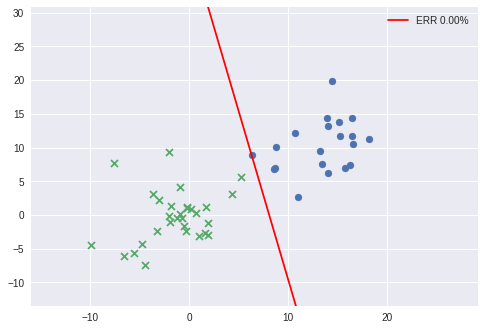

In [9]:
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
params = paramhist[-1:]
w0, w1, w2 = float(params.w0), float(params.w1), float(params.w2)
show_result(subplot, train_set, w0, w1, w2, err_rate)

同じくパラメーターの変化の様子をグラフに表示します。

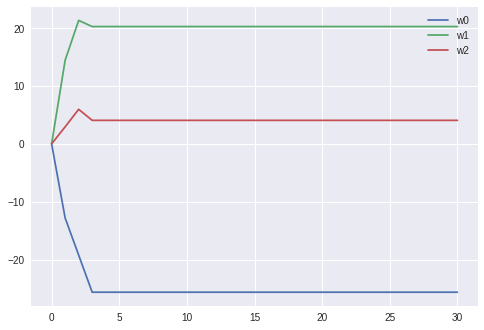

In [10]:
paramhist.plot().legend(loc=1)

### 分類が困難なトレーニングセットの場合

先程よりも分散が大きく、分類な困難なトレーニングセットを用意します。

In [0]:
train_set = prepare_dataset(20, [15,10], 30, 30, [0,0], 30)

トレーニングを実施して、結果をグラフに表示します。

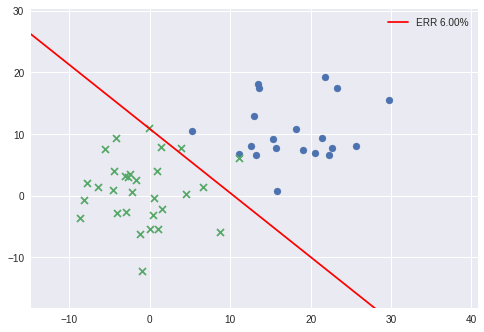

In [12]:
paramhist, err_rate = run_train(train_set)
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
params = paramhist[-1:]
w0, w1, w2 = float(params.w0), float(params.w1), float(params.w2)
show_result(subplot, train_set, w0, w1, w2, err_rate)

同じく、パラメーターの変化をグラフに表示します。

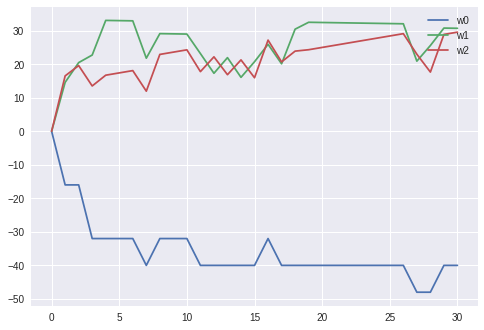

In [13]:
paramhist.plot().legend(loc=1)